In [ ]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install transformers
!pip install matplotlib
!pip install scikit-learn
!pip install torchinfo
!pip install openpyxl


# Import Library

In [234]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt

# Show Dataset

In [235]:
df = pd.read_excel("data/chitchat.xlsx")
df.head()

,label,text
0,date,How is your Friday so far?
1,name,What do you want me to address you?
2,date,How is your day going so far
3,date,How is Sunday going
4,goodbye,I have to sign off


In [236]:
print(df['label'].value_counts())
print("Total label numbers: ", len(np.unique(df['label'])), "\n")

label
goodbye     4
greeting    4
age         4
date        3
name        2
Name: count, dtype: int64
Total label numbers:  5 



# Converting the labels into encodings

In [237]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()

# Fit the LabelEncoder and transform the labels
encoded_labels = le.fit_transform(df['label'])
# Create a mapping between original labels and encoded numbers
label_mapping = dict(zip(df['label'], encoded_labels))
# Print the mapping
print("Label Mapping:")
for label, encoded_label in label_mapping.items():
    print(f"Original Label: {label} -> Encoded Label: {encoded_label}")


df['label'] = le.fit_transform(df['label'])

# check class distribution
print(df['label'].value_counts(normalize = True), "\n")

# In this example we have used all the utterances for training purpose
train_text, train_labels = df['text'], df['label']

# Split the dataset into train and test sets
train_text, test_text, train_labels, test_labels = train_test_split(
  train_text, train_labels, test_size=0.2, random_state=42)

Label Mapping:
Original Label: date -> Encoded Label: 1
Original Label: name -> Encoded Label: 4
Original Label: goodbye -> Encoded Label: 2
Original Label: greeting -> Encoded Label: 3
Original Label: age -> Encoded Label: 0
label
2    0.235294
3    0.235294
0    0.235294
1    0.176471
4    0.117647
Name: proportion, dtype: float64 



# Import Model

In [238]:
# #from transformers import AutoModel, BertTokenizerFast
# # Load the BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# # Import BERT-base pretrained model
# bert = AutoModel.from_pretrained('bert-base-uncased')

#from transformers import RobertaTokenizer, RobertaModel
# # Load the Roberta tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# # Import Roberta pretrained model
# bert = RobertaModel.from_pretrained('roberta-base')

from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

### Sample data distilbert-base-uncased tokenizer

In [239]:
text = ["this is a distil bert model.","data is oil"]
# Encode the text
encoded_input = tokenizer(text, padding=True,truncation=True, return_tensors='pt')
print(encoded_input)

# In input_ids:
# 101 - Indicates beginning of the sentence
# 102 - Indicates end of the sentence
# In attention_mask:
# 1 - Actual token
# 0 - Padded token

{'input_ids': tensor([[  101,  2023,  2003,  1037,  4487, 16643,  2140, 14324,  2944,  1012,
           102],
        [  101,  2951,  2003,  3514,   102,     0,     0,     0,     0,     0,
             0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


# Processing train dataset

### get length of all the messages in the train set

0      6
1      8
2      7
3      3
4      7
5      2
6      9
7      5
8      5
9     10
10     1
11     4
12     4
dtype: int64


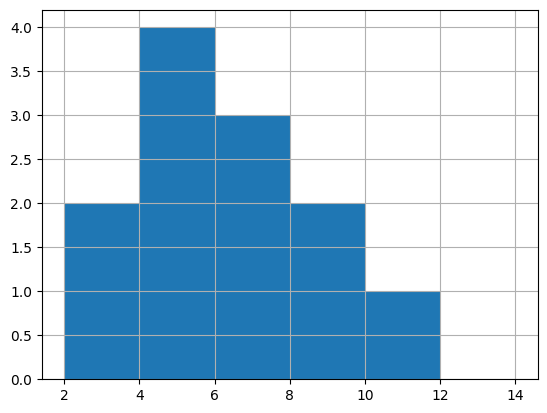

In [240]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

print(pd.Series(seq_len))
pd.Series(seq_len).hist(bins = [2,4,6,8,10,12,14])

# Based on the histogram we are selecting the max len as 8
max_seq_len = 8

### tokenize and encode sequences in the training set

In [241]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
  train_text.tolist(),
  max_length = max_seq_len,
  pad_to_max_length=True,
  truncation=True,
  return_token_type_ids=False
)

# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

c:\Users\hank.yen\VSCode\Python\Project_3(BERT)\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### create dataloaders for the training set

In [242]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Define Model Architecture

### Model 1

In [243]:
class BERT_Arch(nn.Module):
  def __init__(self, bert):      
    super(BERT_Arch, self).__init__()
    self.bert = bert 
      
    # dropout layer
    self.dropout = nn.Dropout(0.2)
      
    # relu activation function
    self.relu =  nn.ReLU()
    # dense layer
    self.fc1 = nn.Linear(768,512)
    self.fc2 = nn.Linear(512,256)
    #self.fc3 = nn.Linear(256,5)
    self.fc3 = nn.Linear(256, len(np.unique(train_labels)))

    #softmax activation function
    self.softmax = nn.LogSoftmax(dim=1)
  
  #define the forward pass
  def forward(self, sent_id, mask):
    #pass the inputs to the model  
    cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
      
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    # output layer
    x = self.fc3(x)
   
    # apply softmax activation
    x = self.softmax(x)
    return x


### Model 2

In [244]:
# # Build the Sentiment Classifier class 
# class SentimentClassifier(nn.Module):
    
#     # Constructor class 
#     def __init__(self, berf):
#         super(SentimentClassifier, self).__init__()
#         self.bert = bert
#         self.drop = nn.Dropout(p=0.3)
#         self.out = nn.Linear(self.bert.config.hidden_size, len(np.unique(train_labels)))
    
#     # Forward propagaion class
#     def forward(self, sent_ids, attention_mask):
#         _, pooled_output = self.bert(
#           input_ids=sent_ids,
#           attention_mask=attention_mask
#         )
#         #  Add a dropout layer 
#         output = self.drop(pooled_output)
#         return self.out(output)

### Model Summary

In [245]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
  param.requires_grad = False

model = BERT_Arch(bert)
# model = SentimentClassifier(bert)
# push the model to GPU
#model = model.to(device)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           1,285
├─LogSoftmax: 1-7                                       --
Total 

# Using AdamW Optimizer

In [246]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

c:\Users\hank.yen\VSCode\Python\Project_3(BERT)\.venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Find Class Weights

In [247]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)
print(class_wts)

[0.65 1.3  0.65 1.3  2.6 ]


### Balancing the weights while calculating the error

In [248]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
#weights = weights.to(device)

# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

# Setting up the epochs

In [249]:
# empty lists to store training and validation loss of each epoch
train_losses=[]

# number of training epochs
epochs = 100

# We can also use learning rate scheduler to achieve better results
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Define Taraining Process

In [250]:
# function to train the model
def train():
  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    
    # push the batch to gpu
    batch = [r for r in batch] 
    sent_id, mask, labels = batch
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # clear calculated gradients
    optimizer.zero_grad()
  
    # We are not using learning rate scheduler as of now
    # lr_sch.step()
    # model predictions are stored on GPU. So, push it to CPU
    # preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  # returns the loss and predictions
  return avg_loss, total_preds

# Define Evaluate Model Function

In [251]:
# Function to evaluate the model on the test set
def evaluate_model(model):

  tokens_test = tokenizer(
  test_text.tolist(),
  max_length=max_seq_len,
  pad_to_max_length=True,
  truncation=True,
  return_token_type_ids=False
  )

  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  test_y = torch.tensor(test_labels.tolist())

  # Create the test dataloader
  test_data = TensorDataset(test_seq, test_mask, test_y)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

  model.eval()
  total_preds = []
  total_labels = []

  with torch.no_grad():
    for batch in test_dataloader:
      batch = [r for r in batch]
      sent_id, mask, labels = batch

      preds = model(sent_id, mask)
      preds = preds.detach().cpu().numpy()
      preds = np.argmax(preds, axis=1)

      total_preds.extend(preds)
      total_labels.extend(labels.cpu().numpy())

  accuracy = (np.array(total_preds) == np.array(total_labels)).mean()
  return accuracy


# Define Calculate Accuracy Function

In [252]:
def calculate_accuracy(preds, labels):
    # Convert the predicted probabilities to predicted class labels
    predicted_labels = np.argmax(preds, axis=1)
    # Calculate accuracy by comparing predicted labels with actual labels
    accuracy = (predicted_labels == labels).mean()
    return accuracy

# Train Model and Save Model

c:\Users\hank.yen\VSCode\Python\Project_3(BERT)\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



 Epoch 1 / 100

Training Loss: 1.606
Training Accuracy: 0.1538
Validation Accuracy: 0.2500

 Epoch 2 / 100

Training Loss: 1.596
Training Accuracy: 0.2308
Validation Accuracy: 0.2500

 Epoch 3 / 100

Training Loss: 1.590
Training Accuracy: 0.1538
Validation Accuracy: 0.2500

 Epoch 4 / 100

Training Loss: 1.552
Training Accuracy: 0.0769
Validation Accuracy: 0.2500

 Epoch 5 / 100

Training Loss: 1.512
Training Accuracy: 0.4615
Validation Accuracy: 0.2500

 Epoch 6 / 100

Training Loss: 1.511
Training Accuracy: 0.0769
Validation Accuracy: 0.2500

 Epoch 7 / 100

Training Loss: 1.449
Training Accuracy: 0.1538
Validation Accuracy: 0.7500

 Epoch 8 / 100

Training Loss: 1.417
Training Accuracy: 0.0769
Validation Accuracy: 0.7500

 Epoch 9 / 100

Training Loss: 1.371
Training Accuracy: 0.3077
Validation Accuracy: 0.7500

 Epoch 10 / 100

Training Loss: 1.327
Training Accuracy: 0.1538
Validation Accuracy: 0.7500

 Epoch 11 / 100

Training Loss: 1.252
Training Accuracy: 0.1538
Validation Acc

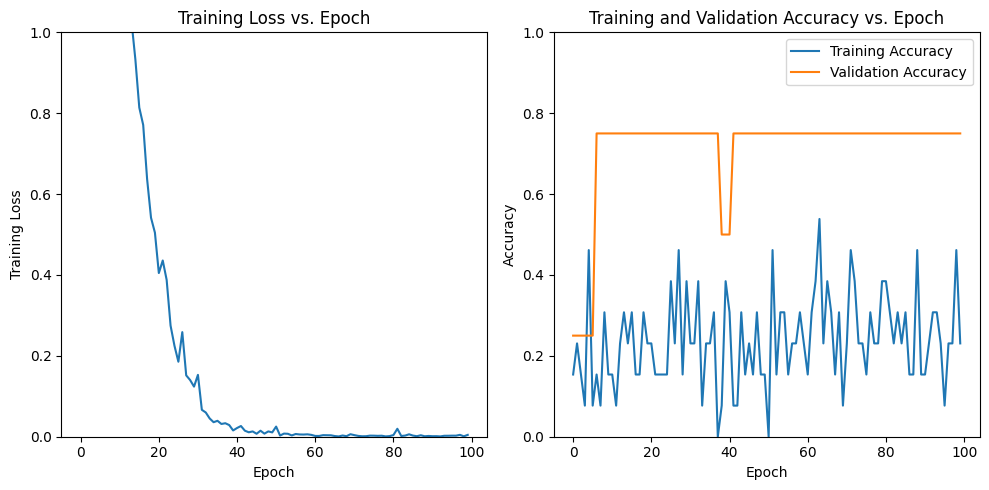

In [253]:
train_losses = []  # Empty list to store training loss of each epoch
train_accuracies = []
validation_accuracies = []

for epoch in range(epochs):
     
  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
  #train model
  train_loss, train_preds = train()


  # Calculate training accuracy
  train_accuracy = calculate_accuracy(train_preds, train_labels)  # This function is above
  train_accuracies.append(train_accuracy)

  # Calculate validation accuracy
  validation_accuracy = evaluate_model(model)  # This function is above
  validation_accuracies.append(validation_accuracy)
    
  # append training and validation loss
  train_losses.append(train_loss)
  # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Training Accuracy: {train_accuracy:.4f}')
  print(f'Validation Accuracy: {validation_accuracy:.4f}')


  if epoch+1 == epochs:
    # Save the tokenizer
    tokenizer.save_pretrained('fine_tuned_model')
    # Save the model's state_dict
    torch.save(model.state_dict(), 'fine_tuned_model/fine_tuned_model.pt')
    print("Model Saved")


# Plotting the training loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


# Get Prediction

### get_prediction() for predicting intent

In [254]:
def get_prediction(str):
  str = re.sub(r'[^a-zA-Z ]+', '', str)
  test_text = [str]
  model.eval()
 
  tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
  )
  test_seq = torch.tensor(tokens_test_data['input_ids'])
  test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
  preds = None
  with torch.no_grad():
    #preds = model(test_seq.to(device), test_mask.to(device))
    preds = model(test_seq, test_mask)

  preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  print("Intent Identified: ", le.inverse_transform(preds)[0])
  return le.inverse_transform(preds)[0]

### get_response for matching intent with tag in json file

In [255]:
# def get_response(message): 
#   with open('intentsDataset.json', 'r') as opened_file: # Opens a Json File
#     data = json.load(opened_file)

#   intent = get_prediction(message)
#   for i in data['intents']: 
#     if i["tag"] == intent:
#       result = random.choice(i["responses"])
#       break

#   print(f"Response : {result}")
#   return "Intent: "+ intent + '\n' + "Response: " + result

### predict message

In [256]:
tryMessage = 'I have to sign off'
print("tryMessage: " + tryMessage + "\n" + "intent: " + get_prediction(tryMessage))

# tryMessage = 'why dont you introduce yourself'
# print("tryMessage: " + tryMessage + "\n" + get_response(tryMessage))
# # get_response('why dont you introduce yourself')

Intent Identified:  goodbye
tryMessage: I have to sign off
intent: goodbye


# Evaluate Model (This section has been defined already (i.e. define evaluate model function))

In [257]:
# Function to evaluate the model on the test set
def evaluate_model(model):

  tokens_test = tokenizer(
  test_text.tolist(),
  max_length=max_seq_len,
  pad_to_max_length=True,
  truncation=True,
  return_token_type_ids=False
  )

  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  test_y = torch.tensor(test_labels.tolist())

  # Create the test dataloader
  test_data = TensorDataset(test_seq, test_mask, test_y)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

  model.eval()
  total_preds = []
  total_labels = []

  with torch.no_grad():
    for batch in test_dataloader:
      batch = [r for r in batch]
      sent_id, mask, labels = batch

      preds = model(sent_id, mask)
      preds = preds.detach().cpu().numpy()
      preds = np.argmax(preds, axis=1)

      total_preds.extend(preds)
      total_labels.extend(labels.cpu().numpy())

  accuracy = (np.array(total_preds) == np.array(total_labels)).mean()
  return accuracy

print(f"Test Accuracy: {evaluate_model(model):.4f}")

Test Accuracy: 0.7500


c:\Users\hank.yen\VSCode\Python\Project_3(BERT)\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
